In [38]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import sem
from sklearn.metrics import RocCurveDisplay
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.model_selection import RandomizedSearchCV
from time import time
from scipy.stats import sem
#from sklearn.inspection import permutation_importance
import pickle
from joblib import dump, load



## Load Data

In [126]:
#LOAD DATA
dataDir = 'CleanDataFinal'

#LOAD TRAINING DATA
#features
path = os.path.join(dataDir, 'trainFeaturesFinal.csv')
train_x_pd = pd.read_csv (path, index_col = 'HHX')
train_x = train_x_pd.to_numpy()
print(train_x.shape)

#target
path = os.path.join(dataDir, 'trainTargetFinal.csv')
train_y_pd = pd.read_csv (path, index_col = 'HHX')
train_y = train_y_pd.to_numpy().flatten()
print(train_y.shape)

#LOAD TESTING DATA
#features
path = os.path.join(dataDir, 'testFeaturesFinal.csv')
test_x_pd = pd.read_csv (path, index_col = 'HHX')
test_x = test_x_pd.to_numpy()
print(test_x.shape)

#target
path = os.path.join(dataDir, 'testTargetFinal.csv')
test_y_pd = pd.read_csv (path, index_col = 'HHX')
test_y = test_y_pd.to_numpy().flatten()
print(test_y.shape)


(22222, 5290)
(22222,)
(5556, 5290)
(5556,)


In [59]:
#TAKE GAD COLUMNS OUT
#for training model without relying on GAD survey 

#training data
#find GAD columns
cols_GAD = train_x_pd.columns[train_x_pd.columns.str.contains('GAD')]
#drop them
train_x_pd = train_x_pd.drop(columns=cols_GAD)
train_x = train_x_pd.to_numpy()
#check GAD columns are gone
cols_GAD = train_x_pd.columns[train_x_pd.columns.str.contains('GAD')]
print('GAD cols left in training: ', str(len(cols_GAD)))

#testing data
#find GAD columns
cols_GAD = test_x_pd.columns[test_x_pd.columns.str.contains('GAD')]
#drop them
test_x_pd = test_x_pd.drop(columns=cols_GAD)
test_x = test_x_pd.to_numpy()
#check GAD columns are gone
cols_GAD = test_x_pd.columns[test_x_pd.columns.str.contains('GAD')]
print('GAD cols left in testing: ', str(len(cols_GAD)))


GAD cols left in training:  0
GAD cols left in testing:  0


## Model Optimization

In [60]:
#RANDOMIZED SEARCH FOR BEST PARAMETERS
#adapted from https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py
print("Fitting the classifier to the training set")
t0 = time()

#set up paramter grid
n_features = train_x.shape[0]
param_grid = {
    "n_estimators": np.arange(10, 500).astype(int),
    "max_features": np.arange(10, np.sqrt(n_features)).astype(int)
}

clf = RandomizedSearchCV(RandomForestClassifier(), param_grid, n_iter=15, scoring='roc_auc_ovr_weighted', cv=5)
clf = clf.fit(train_x, train_y)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 12803.665s
Best estimator found by grid search:
RandomForestClassifier(max_features=139, n_estimators=348)


In [61]:
#TABLE OF RESULTS
cv_res = pd.DataFrame(clf.cv_results_)
#save data
path = 'RFC_opt_noGAD.csv'
cv_res.to_csv(path)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,49.023785,0.671084,0.555898,0.032964,402,25,"{'n_estimators': 402, 'max_features': 25}",0.883135,0.899046,0.879817,0.890149,0.895557,0.890979,0.880358,0.885669,0.895141,0.884042,0.888389,0.006420,13
1,150.160247,4.759502,0.502766,0.056524,429,79,"{'n_estimators': 429, 'max_features': 79}",0.896903,0.908048,0.891387,0.898970,0.901769,0.902070,0.886326,0.894841,0.903786,0.893034,0.897713,0.006174,5
2,68.100094,1.120687,0.372408,0.015365,298,52,"{'n_estimators': 298, 'max_features': 52}",0.891812,0.905761,0.884601,0.897835,0.898229,0.898627,0.883659,0.890866,0.901503,0.890479,0.894337,0.006854,8
3,29.910664,0.674823,0.105396,0.005089,64,101,"{'n_estimators': 64, 'max_features': 101}",0.886042,0.899654,0.890086,0.893459,0.896761,0.893660,0.877664,0.886749,0.899230,0.886652,0.890996,0.006551,12
4,39.403710,4.975327,0.183718,0.133185,93,87,"{'n_estimators': 93, 'max_features': 87}",0.892545,0.904622,0.887966,0.900215,0.898996,0.898903,0.879171,0.892358,0.901333,0.892656,0.894877,0.007138,7
5,109.045652,1.996721,0.308390,0.025698,254,96,"{'n_estimators': 254, 'max_features': 96}",0.894555,0.906209,0.890392,0.898660,0.902208,0.904678,0.887144,0.893272,0.904250,0.895121,0.897649,0.006215,6
6,224.304424,5.042561,0.374903,0.014303,348,139,"{'n_estimators': 348, 'max_features': 139}",0.895369,0.910166,0.894057,0.900948,0.904313,0.905624,0.890479,0.897322,0.904441,0.893969,0.899669,0.006034,1
7,34.413136,0.912147,0.136784,0.005780,97,78,"{'n_estimators': 97, 'max_features': 78}",0.891902,0.902001,0.884014,0.892888,0.897470,0.900641,0.881197,0.892557,0.897145,0.889747,0.892956,0.006392,10
8,56.194274,1.201862,0.309856,0.002891,253,50,"{'n_estimators': 253, 'max_features': 50}",0.891297,0.906617,0.888266,0.897207,0.897701,0.898189,0.882362,0.890538,0.899786,0.889194,0.894116,0.006669,9
9,11.305809,0.541820,0.162929,0.005821,100,19,"{'n_estimators': 100, 'max_features': 19}",0.871768,0.892668,0.869153,0.886938,0.882938,0.886928,0.868743,0.880961,0.881419,0.878038,0.879955,0.007643,15


In [127]:
#LOAD DATA
datadir = 'AnalysisData'
datafile = 'RFC_opt_fullData'+'.csv'
path = os.path.join(datadir, datafile)
cv_res = pd.read_csv(path, index_col=0)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,102.750550,6.337389,0.316782,0.023288,303,79,"{'n_estimators': 303, 'max_features': 79}",0.924090,0.931998,0.921425,0.926055,0.921326,0.924695,0.915519,0.924263,0.928557,0.917060,0.923499,0.004700,7
1,113.708027,1.449527,0.441748,0.003953,414,63,"{'n_estimators': 414, 'max_features': 63}",0.922669,0.932811,0.918685,0.925725,0.920688,0.923119,0.914872,0.925145,0.927927,0.917207,0.922885,0.005061,10
2,100.438595,1.458386,0.332732,0.004658,312,73,"{'n_estimators': 312, 'max_features': 73}",0.920892,0.932777,0.920584,0.927111,0.922425,0.923721,0.916268,0.925785,0.929277,0.918701,0.923754,0.004784,5
3,67.469908,1.852778,0.158629,0.003559,132,111,"{'n_estimators': 132, 'max_features': 111}",0.923380,0.932592,0.920358,0.925003,0.921359,0.922885,0.915133,0.921295,0.930020,0.917427,0.922945,0.005009,9
4,126.235345,6.431756,0.346687,0.024500,338,86,"{'n_estimators': 338, 'max_features': 86}",0.924620,0.933847,0.921828,0.926049,0.920734,0.923478,0.916661,0.926012,0.930586,0.920235,0.924405,0.004807,3
5,43.609561,0.432059,0.494376,0.019248,397,22,"{'n_estimators': 397, 'max_features': 22}",0.911246,0.924238,0.909515,0.917168,0.912315,0.913021,0.905134,0.913867,0.919200,0.906132,0.913183,0.005543,14
6,247.989021,7.087082,0.447320,0.012066,461,118,"{'n_estimators': 461, 'max_features': 118}",0.926836,0.933433,0.922166,0.928812,0.922781,0.927735,0.916972,0.927109,0.931856,0.920047,0.925775,0.004938,1
7,80.420632,2.396207,0.236554,0.006289,216,84,"{'n_estimators': 216, 'max_features': 84}",0.922230,0.932561,0.919234,0.926502,0.921946,0.923927,0.914203,0.924197,0.929664,0.917926,0.923239,0.005185,8
8,206.666216,7.802738,0.381595,0.023695,392,116,"{'n_estimators': 392, 'max_features': 116}",0.925813,0.934639,0.922928,0.929207,0.922626,0.927779,0.916224,0.926641,0.931772,0.919484,0.925711,0.005290,2
9,11.984460,1.638426,0.058581,0.002945,19,125,"{'n_estimators': 19, 'max_features': 125}",0.906835,0.915850,0.904828,0.909711,0.906684,0.913093,0.891819,0.908505,0.914247,0.906437,0.907801,0.006378,15


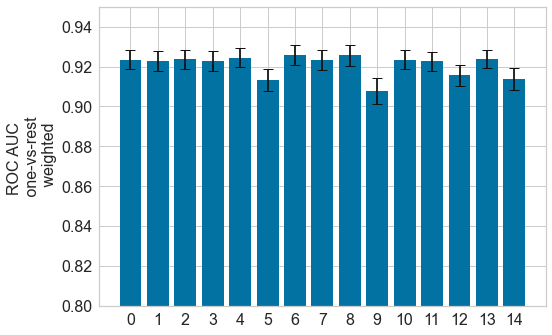

In [128]:
#GRAPH CV RESULTS

#gather scores for each CV iteration 
scores = cv_res.loc[:, cv_res.columns[cv_res.columns.str.contains('split')].tolist()]

#make bar graph of scores per model
model_names=[]
for model in scores.index:
    plt.bar(model, np.mean(scores.iloc[model]), color ='b')
    plt.errorbar(model, np.mean(scores.iloc[model]), yerr=np.std(scores.iloc[model]), capsize=5, markeredgewidth=1, color='k')
    model_names.append(str(model))
plt.xticks(scores.index, model_names, fontsize=16)    
plt.ylim(bottom=0.8, top=0.95)
plt.yticks(fontsize=16)
plt.ylabel('Model', fontsize=16)
plt.ylabel('ROC AUC \n one-vs-rest \n weighted', fontsize=16)
    
plt.show()

In [129]:
#TRAIN USING BEST PARAMETERS AND ALL TRAINING DATA

#grab best model
best = cv_res[cv_res.rank_test_score == 1]

#create new random forest object with best parameters
n_estimators = best.param_n_estimators.to_numpy()[0]
max_features = best.param_max_features.to_numpy()[0]

RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
#train model
t0 = time()

RFC.fit(train_x, train_y)
print('n_estimators', n_estimators)
print('max_features', max_features)
print("done in %0.3fs" % (time() - t0))

n_estimators 461
max_features 118
done in 201.299s


In [130]:
#CALCULATE FINAL TESTING SCORE
roc_auc_test = roc_auc_score(test_y, RFC.predict_proba(test_x), multi_class='ovr', average='weighted')
roc_auc_test

0.9207228209415602

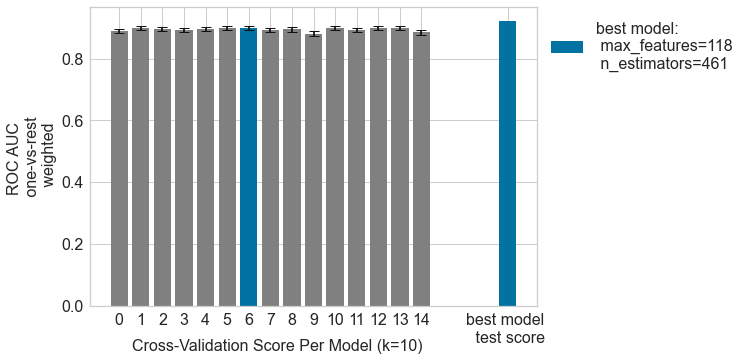

In [132]:
#GRAPH BEST TEST SCORE WITH TRAINING SCORES

#gather scores for each CV iteration for models that are not the best
#make dataframe of the results
cv_res = pd.DataFrame(clf.cv_results_)
#drop rank 1
not_best = cv_res[cv_res.rank_test_score != 1]
#get scores
not_best_scores = not_best.loc[:, not_best.columns[not_best.columns.str.contains('split')].tolist()]

#get training scores for best model 
best = cv_res[cv_res.rank_test_score == 1]
#get scores
best_scores = best.loc[:, best.columns[best.columns.str.contains('split')].tolist()]

#make bar graph of cv scores for not best model
model_names=[]
for model in not_best_scores.index:
    plt.bar(model, np.mean(not_best_scores.loc[model]), color ='gray')
    plt.errorbar(model, np.mean(not_best_scores.loc[model]), yerr=np.std(not_best_scores.loc[model]), 
                 capsize=5, markeredgewidth=1, color='k')
    
#bar graph of cv scores and final for best model 
plt.bar(best_scores.index[0], np.mean(best_scores.loc[best_scores.index[0]]), color ='b', 
        label='best model: \n max_features='
        + str(max_features) 
        + '\n n_estimators=' 
        + str(n_estimators)
       )
plt.errorbar(best_scores.index[0], np.mean(best_scores.loc[best_scores.index[0]]), 
                                           np.std(best_scores.loc[best_scores.index[0]]), capsize=5, 
                                               markeredgewidth=1, color='k')
x_test_score=len(cv_res)+3
plt.bar(x_test_score, roc_auc_test, color ='b')

#x axis formatting
xticks = np.arange(len(cv_res))
xtick_labels = xticks.astype(str)
xticks = np.append(xticks, x_test_score)
xtick_labels = np.append(xtick_labels, 'best model \n test score')
plt.xticks(xticks, xtick_labels, fontsize=16)    

x_lim=plt.gca().get_xlim()
x_text=x_lim[0]+x_lim[1]*0.1

y_lim=plt.gca().get_ylim()
y_text=y_lim[0]-y_lim[1]*0.15
plt.text(x_text, y_text,'Cross-Validation Score Per Model (k=10)', fontsize=16)

#y axis formatting
plt.yticks(fontsize=16)

#general formatting
plt.legend(bbox_to_anchor=(1, 1), frameon=False, fontsize=16)
plt.ylabel('ROC AUC \n one-vs-rest \n weighted', fontsize=16)

#save figure
path='FullData_Opt.png'
plt.savefig(path, bbox_inches="tight")
    
plt.show()

In [133]:
#SAVE MODEL
RFC_FullData = pickle.dumps(RFC)
dump(RFC, 'RFC_FullData.joblib') 

['RFC_FullData.joblib']